In [11]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import datetime
import baostock as bs
import backtrader as bt
import numpy as np
import pandas as pd

In [27]:
def fetch_data_baostock_backtrader(stock_code, ndays = 365, fig = True):
    lg = bs.login()
    s_date = (datetime.datetime.now() - datetime.timedelta(days = ndays))
    e_date = datetime.datetime.now()
    data_list = []
    rs = bs.query_history_k_data_plus('sz.300661', 'date,open,high,low,close,volume', 
                                      start_date=s_date.strftime('%Y-%m-%d'), 
                                      end_date=e_date.strftime('%Y-%m-%d'), 
                                      frequency="d")
    result = pd.DataFrame(columns=['date','open','high','low','close','volume'])
    i = 0
    while (rs.error_code == '0') & rs.next():
        result.loc[i, ] = rs.get_row_data()
        i += 1
    result.index=pd.to_datetime(result.date)
    result.drop('date', axis=1, inplace = True)
    result = result.astype('float')
    result['openinterest'] = 0
    bs.logout()
    if fig:
        plt.plot(result.index, result.close.astype('float'), color = 'r')
        plt.show()
    return result, s_date, e_date

In [66]:
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)

In [1]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        maperiod=range(10, 31))
    
    # Create a Data Feed
    rawdata, s, e = fetch_data_baostock_backtrader('002305.sz', 365, False)
    data = bt.feeds.PandasData(dataname=rawdata,fromdate=s,todate=e)
    
    # Add the Data Feed to Cerebo
    cerebro.adddata(data)
    
    # Set our desired cash start
    cerebro.broker.setcash(10000.00)
    
    # 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)
    
    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    # Run over everything
    cerebro.run(maxcpus=1)
    
    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

NameError: name 'bt' is not defined

<IPython.core.display.Javascript object>


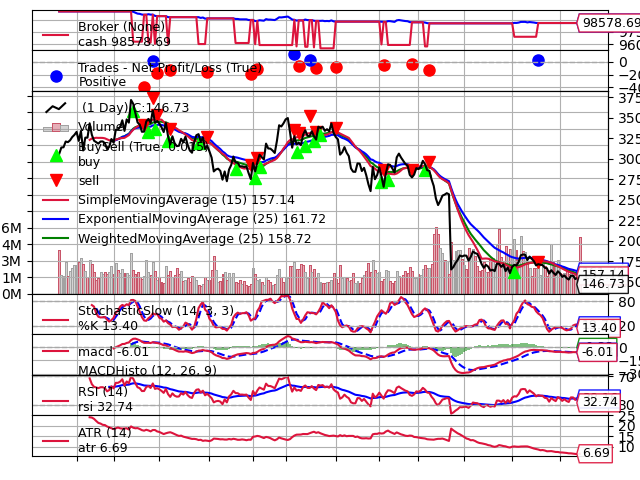

[[<Figure size 640x480 with 8 Axes>]]

In [61]:
cerebro.plot()